In [1]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *

In [2]:
file_path = '../Features/rabbit_corrvar.xlsx'
df = pd.read_excel(file_path)
df.head()

,Irritation,MaxAbsEStateIndex,MinAbsEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,AvgIpc,...,fr_ketone_Topliss,fr_methoxy,fr_nitro,fr_nitro_arom_nonortho,fr_para_hydroxylation,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_unbrch_alkane,fr_urea
0,1,0.380977,0.301948,0.403803,0.385193,0.187251,0.199575,0.550820,0.588235,0.452681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.277350,0.0
1,1,0.443959,0.118847,0.725612,0.470253,0.326442,0.202175,0.550534,0.560784,0.542612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,1,0.049599,0.376730,0.440935,0.382546,0.249141,0.032276,0.304644,0.633987,0.404010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160128,0.0
3,1,0.297132,0.200094,0.634828,0.454915,0.257268,0.120148,0.629576,0.650624,0.467685,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,1,0.067411,0.305414,0.501957,0.647698,0.225299,0.075490,0.315990,0.835294,0.471625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [3]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

In [19]:

# First, split data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=5)


# Print dataset sizes
print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Train set: 1424 samples
Test set: 356 samples


In [22]:
def objective(trial):

    param = {
        "C": trial.suggest_float("C", 0.5, 0.9, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "rbf"]),
        "gamma": "scale",
        "class_weight" : "balanced",
    }
    

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    valid_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model = SVC(**param, probability=True) 
        model.fit(X_train_cv, y_train_cv)
 
        valid_acc = accuracy_score(y_valid_cv, model.predict(X_valid_cv))
        valid_scores.append(valid_acc)

    return np.mean(valid_scores)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best trial:", study.best_trial.params)

[I 2025-03-30 17:34:01,419] A new study created in memory with name: no-name-58a48ca1-9941-4e51-980e-8a780c4ee9e2
[I 2025-03-30 17:34:02,869] Trial 0 finished with value: 0.7970620212503089 and parameters: {'C': 0.7820466035577714, 'kernel': 'rbf'}. Best is trial 0 with value: 0.7970620212503089.
[I 2025-03-30 17:34:03,806] Trial 1 finished with value: 0.7486137879911046 and parameters: {'C': 0.5562494373648423, 'kernel': 'linear'}. Best is trial 0 with value: 0.7970620212503089.
[I 2025-03-30 17:34:04,741] Trial 2 finished with value: 0.7486162589572524 and parameters: {'C': 0.6082821192728597, 'kernel': 'linear'}. Best is trial 0 with value: 0.7970620212503089.
[I 2025-03-30 17:34:05,673] Trial 3 finished with value: 0.7556436866814924 and parameters: {'C': 0.7688312537312618, 'kernel': 'linear'}. Best is trial 0 with value: 0.7970620212503089.
[I 2025-03-30 17:34:07,011] Trial 4 finished with value: 0.7970620212503089 and parameters: {'C': 0.785726041533304, 'kernel': 'rbf'}. Best i

Best trial: {'C': 0.8988061531616598, 'kernel': 'rbf'}


In [23]:
test_accuracies = []
train_accuracies = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    best_params = study.best_trial.params

    # Initialize the KNN model with best parameters
    final_model = SVC(**best_params, probability=True)

    # Fit the model on the training data
    final_model.fit(X_train, y_train)


    test_accuracy = final_model.score(X_test, y_test)
    train_accuracy = final_model.score(X_train, y_train)
    #print("Train Accuracy:", train_accuracy)
    #print("Test Accuracy:", test_accuracy)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print(np.mean(train_accuracies), np.mean(test_accuracies))

0.8631320224719101 0.8401685393258427


Final Model Accuracy on Test: 0.8576779026217228


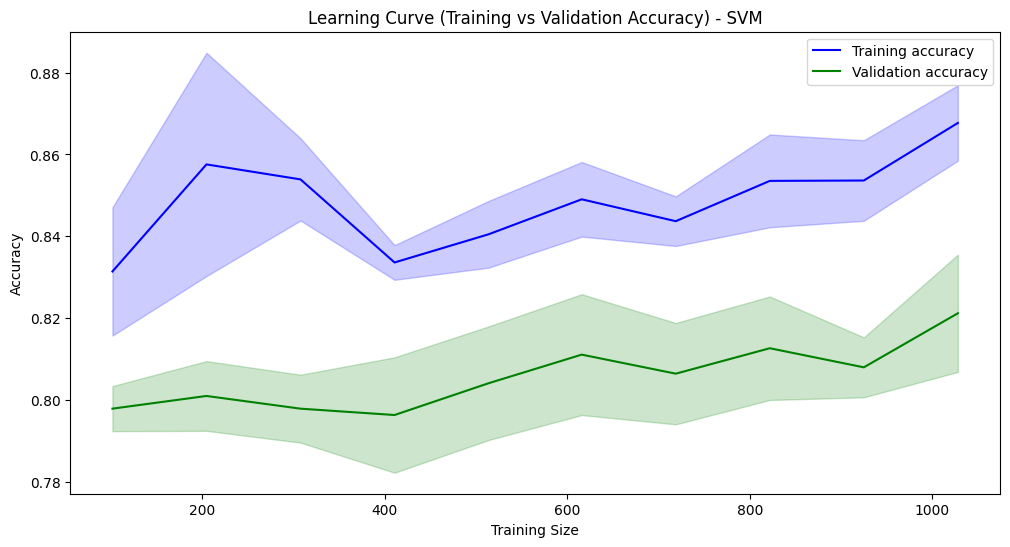

Train Accuracy: 0.8693623639191291
Test Accuracy: 0.8576779026217228


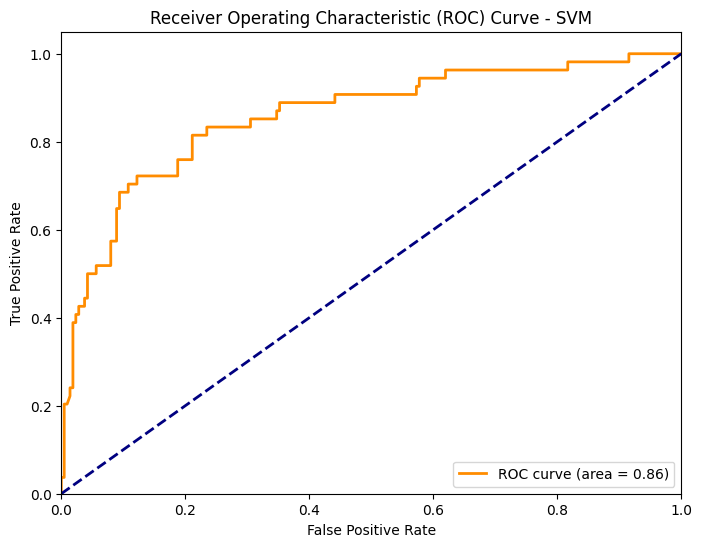

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt

# Get best hyperparameters from study
best_params = study.best_trial.params
best_params =  {'C': 0.6279728945930269, 'kernel': 'poly'}

# Initialize the KNN model with best parameters
final_model = SVC(**best_params, probability=True)

# Fit the model on the training data
final_model.fit(X_train, y_train)

# Evaluate final model on test data
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy on Test:", accuracy_score(y_test, y_pred_final))

# Learning Curves
train_sizes, train_scores, validation_scores = learning_curve(
    final_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy) - SVM')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# ROC Curve
y_prob = final_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM')
plt.legend(loc='lower right')
plt.show()


In [8]:
sample_X = shap.sample(X_train, 200)  # Reduce sample size (e.g., 500)

background_summary = shap.sample(X_train, 25)
explainer = shap.KernelExplainer(final_model.predict_proba, background_summary)

shap_values = explainer.shap_values(sample_X)

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
shap.summary_plot(shap_values[:,:,1], X_train)

In [24]:
import joblib

# Assuming 'model' is your trained QSAR model
joblib.dump(final_model, 'svm_model.pkl')

print("Model saved successfully!")


Model saved successfully!
